In [ ]:
pip install spotipy requests

In [20]:
import pandas as pd
import numpy as np
import json
import re 
import os
import sys
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [144]:
df = pd.read_csv(r"C:\Users\ghosh\OneDrive\Desktop\Spotifyreccosys\archive (2)\spotify_songs.csv")
print("Dataset Shape:", df.shape)
print("Dataset Columns:", df.columns)
print("First few rows of the dataset:")

Dataset Shape: (32833, 23)
Dataset Columns: Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms'],
      dtype='object')
First few rows of the dataset:


In [145]:
df.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [4]:
float_cols = df.dtypes[df.dtypes == 'float64'].index.values

In [3]:
ohe_cols = 'track_popularity'

In [10]:
df['track_popularity'].describe()

count    32833.000000
mean        42.477081
std         24.984074
min          0.000000
25%         24.000000
50%         45.000000
75%         62.000000
max        100.000000
Name: track_popularity, dtype: float64

In [6]:
def ohe_prep(df, column, new_name): 
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

# Check the shape of the DataFrame
print("Shape of the DataFrame:", df.shape)

# Check the column names
print("Column names in the DataFrame:", df.columns)

# Check for NaN values in the DataFrame
print("Number of NaN values in each column:\n", df.isna().sum())

# Display the first 10 rows
df.head(10)


Shape of the DataFrame: (32833, 23)
Column names in the DataFrame: Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms'],
      dtype='object')
Number of NaN values in each column:
 track_id                    0
track_name                  5
track_artist                5
track_popularity            0
track_album_id              0
track_album_name            5
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0


,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052
5,7fvUMiyapMsRRxr07cU8Ef,Beautiful People (feat. Khalid) - Jack Wins Remix,Ed Sheeran,67,2yiy9cd2QktrNvWC2EUi0k,Beautiful People (feat. Khalid) [Jack Wins Remix],2019-07-11,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,8,-5.385,1,0.1270,0.0799,0.000000,0.1430,0.585,124.982,163049
6,2OAylPUDDfwRGfe0lYqlCQ,Never Really Over - R3HAB Remix,Katy Perry,62,7INHYSeusaFlyrHSNxm8qH,Never Really Over (R3HAB Remix),2019-07-26,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,5,-4.788,0,0.0623,0.1870,0.000000,0.1760,0.152,112.648,187675
7,6b1RNvAcJjQH73eZO4BLAB,Post Malone (feat. RANI) - GATTÜSO Remix,Sam Feldt,69,6703SRPsLkS4bPtMFFJes1,Post Malone (feat. RANI) [GATTÜSO Remix],2019-08-29,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,4,-2.419,0,0.0434,0.0335,0.000005,0.1110,0.367,127.936,207619
8,7bF6tCO3gFb8INrEDcjNT5,Tough Love - Tiësto Remix / Radio Edit,Avicii,68,7CvAfGvq4RlIwEbT9o8Iav,Tough Love (Tiësto Remix),2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,8,-3.562,1,0.0565,0.0249,0.000004,0.6370,0.366,127.015,193187
9,1IXGILkPm0tOCNeq00kCPa,If I Can't Have You - Gryffin Remix,Shawn Mendes,67,4QxzbfSsVryEQwvPFEV5Iu,If I Can't Have You (Gryffin Remix),2019-06-20,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,2,-4.552,1,0.0320,0.0567,0.000000,0.0919,0.590,124.957,253040


In [8]:
df['playlist_genre'].head()

0    pop
1    pop
2    pop
3    pop
4    pop
Name: playlist_genre, dtype: object

In [9]:
df['ids'] = df.index  # Assigns the DataFrame index as IDs
df['playlist_genre'] = df['playlist_genre'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])
# Display the DataFrame with the 'ids' column
df.head()


,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,ids
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,[],...,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754,0
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,[],...,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600,1
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,[],...,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616,2
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,[],...,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093,3
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,[],...,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052,4


In [ ]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import os
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

scope = 'user-library-read'
# Set environment variables within the notebook
os.environ['SPOTIPY_CLIENT_ID'] = '66c71035c85145dba5fbde32031bd3d2'
os.environ['SPOTIPY_CLIENT_SECRET'] = 'c8b6bf398fae43199798c917a6825ce6'
os.environ['SPOTIPY_REDIRECT_URI'] = 'https://localhost:8000'
if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

# Set a custom cache path
cache_path = './spotify_cache'

# Authentication with Spotify
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope, cache_path='./spotify_cache'))

# Function to fetch all tracks in the playlist
def get_playlist_tracks(sp, playlist_id):
    results = sp.playlist_tracks(playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

# Function to get genres for an artist
def get_artist_genres(sp, artist_id):
    artist = sp.artist(artist_id)
    return artist['genres']

# Function to get popularity for an artist
def get_artist_popularity(sp, artist_id):
    artist = sp.artist(artist_id)
    return artist['popularity']

# Function to extract relevant data and create track_info
def extract_track_info(track):
    track_info = {}
    features = sp.audio_features(track['id'])[0]
    album = track['album']
    # release_year = get_release_year(album)
    artists = track['artists']
    artist_names = [artist['name'] for artist in artists]
    artist_ids = [artist['id'] for artist in artists]
    artist_genres = [get_artist_genres(sp, artist_id) for artist_id in artist_ids]
    genres = [genre for genres_list in artist_genres for genre in genres_list]  # Flatten genres list
    artist_popularity = [get_artist_popularity(sp, artist_id) for artist_id in artist_ids]

    track_info = {
        'name': track['name'],
        'artist': ", ".join(artist_names),
        'genres': ", ".join(genres),
        'id': track['id'],  # <-- Assigning the actual track ID here
        'popularity': sum(artist_popularity) / len(artist_popularity) if artist_popularity else 0,
        'album': track['album']['name'],
        'year': release_year,
        'danceability': features['danceability'],
        'energy': features['energy'],
        'key': features['key'],
        'loudness': features['loudness'],
        'mode': features['mode'],
        'speechiness': features['speechiness'],
        'acousticness': features['acousticness'],
        'instrumentalness': features['instrumentalness'],
        'liveness': features['liveness'],
        'popularity_red': int(track['popularity'] / 5) if 'popularity' in track else 0,
        'valence': features['valence'],
        'tempo': features['tempo']
    }
    return track_info

# Fetch playlist tracks
playlist_id = "37i9dQZF1EIZCsyhLFyG4d"
tracks = get_playlist_tracks(sp, playlist_id)
print(f"Number of tracks retrieved: {len(tracks)}")

# Extract relevant data for each track
track_data = []
for item in tracks:
    track = item['track']
    track_info = extract_track_info(track)
    track_data.append(track_info)

# Create DataFrame
df = pd.DataFrame(track_data)
print("DataFrame created successfully")

# Display the DataFrame
df.head()


Number of tracks retrieved: 50


In [14]:
df['playlist_genre'].head()

0    []
1    []
2    []
3    []
4    []
Name: playlist_genre, dtype: object

In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

# Function to preprocess the genres data
def preprocess_genres(genres):
    if isinstance(genres, str) and genres.strip():
        return genres.replace(",", " ")
    return "unknown_genre"  # Default genre if empty

# Apply the preprocessing function to the genres column
df['playlist_genre'] = df['playlist_genre'].apply(preprocess_genres)

# Check if the genres column is not empty
print(df['playlist_genre'].head())

# Function to create feature set
def create_feature_set(df, float_cols):
    # Normalize float columns
    scaler = MinMaxScaler()
    df[float_cols] = scaler.fit_transform(df[float_cols])
    
    # Tfidf genre lists
    tfidf = TfidfVectorizer(stop_words=None)  # Ensure no stop words are removed
    tfidf_matrix = tfidf.fit_transform(df['playlist_genre'])
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['playlist_genre' + "|" + i for i in tfidf.get_feature_names_out()]
    
    # Concatenate the genre data with the original DataFrame
    complete_feature_set = pd.concat([df, genre_df], axis=1)
    return complete_feature_set

# Create the feature set
complete_feature_set = create_feature_set(df, float_cols=float_cols)

# Display the feature set
complete_feature_set.head()


0    pop
1    pop
2    pop
3    pop
4    pop
Name: playlist_genre, dtype: object


,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,instrumentalness,liveness,valence,tempo,duration_ms,playlist_genre|edm,playlist_genre|latin,playlist_genre|pop,playlist_genre|rap,playlist_genre|rock
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,0.000000,0.065562,0.522704,0.509673,194754,0.0,0.0,1.0,0.0,0.0
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,0.004235,0.358434,0.699294,0.417524,162600,0.0,0.0,1.0,0.0,0.0
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,0.000023,0.110442,0.618567,0.517908,176616,0.0,0.0,1.0,0.0,0.0
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,0.000009,0.204819,0.279516,0.509338,169093,0.0,0.0,1.0,0.0,0.0
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,0.000000,0.083635,0.731584,0.517775,189052,0.0,0.0,1.0,0.0,0.0


Initial Playlist DataFrame:
Input DataFrame:
Filtered Playlist DataFrame:
                        id                date_added
0   1mdxuS3vvltUbL3Brs9nqQ 2024-01-09 16:15:51+00:00
1   5SkRLpaGtvYPhw02vZhQQ9 2024-01-27 09:19:15+00:00
2   7KA4W4McWYRpgf0fWsJZWB 2024-01-27 09:19:36+00:00
3   5KUNwkaNf8l5A9sXZhiCgI 2024-01-27 09:19:48+00:00
4   6OkDb9fyi22Pr6QJIrUNdJ 2024-01-27 09:19:54+00:00
5   5B0kgjHULYJhAQkK5XsMoC 2024-01-27 09:20:02+00:00
6   3jHdKaLCkuNEkWcLVmQPCX 2024-01-27 09:20:10+00:00
7   5467KZaTToEB680WvOd9w5 2024-01-27 09:20:20+00:00
8   3JJL91ilRV6fXhKqu0FGXs 2024-01-28 08:30:43+00:00
9   1otG6j1WHNvl9WgXLWkHTo 2024-02-27 14:15:17+00:00
10  6LOZws7T3jqZz78unPgFF9 2024-02-27 14:15:25+00:00
11  3FsqOTQT3d7c296eStnEnl 2024-03-07 05:53:53+00:00
12  0VA5FzFlysCcSG1IdOkhUb 2024-03-07 06:34:47+00:00
                        id                date_added
12  0VA5FzFlysCcSG1IdOkhUb 2024-03-07 06:34:47+00:00
11  3FsqOTQT3d7c296eStnEnl 2024-03-07 05:53:53+00:00
10  6LOZws7T3jqZz78unPgFF

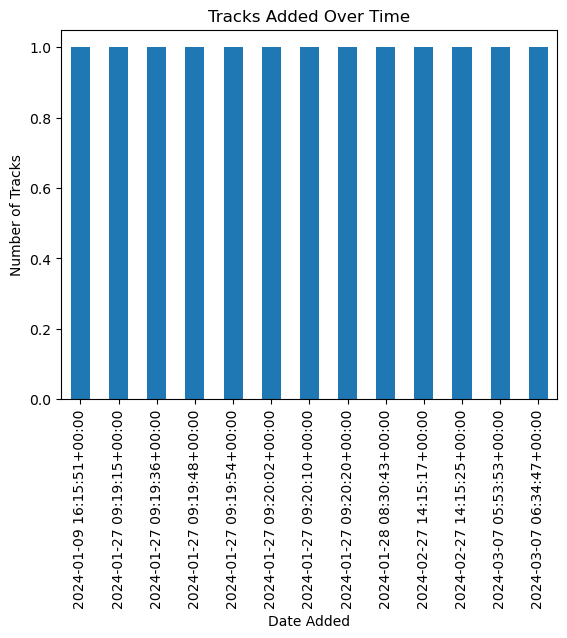

In [13]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd
import matplotlib.pyplot as plt

# Replace with your Spotify Developer credentials
client_id = '66c71035c85145dba5fbde32031bd3d2'
client_secret = 'c8b6bf398fae43199798c917a6825ce6'
redirect_uri = 'https://localhost:8000'
scope = 'user-library-read playlist-read-private'

# Authenticate and get the access token
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id,
                                               client_secret=client_secret,
                                               redirect_uri=redirect_uri,
                                               scope=scope))

# Function to create necessary outputs
def create_necessary_outputs(playlist_name, id_dic, df):
    # Initialize an empty DataFrame with specified columns
    playlist = pd.DataFrame(columns=['id', 'date_added'])
    
    # Populate the DataFrame with track IDs and added dates
    for ix, i in enumerate(id_dic):
        playlist.loc[ix, 'id'] = i['track']['id']
        playlist.loc[ix, 'date_added'] = i['added_at']
    
    # Convert date_added column to datetime format
    playlist['date_added'] = pd.to_datetime(playlist['date_added'])
    
    # Print the initial playlist DataFrame
    print("Initial Playlist DataFrame:")
    playlist
    
    # Print the input DataFrame
    print("Input DataFrame:")
    df.head()
    
    # Filter the playlist DataFrame based on the IDs present in the input DataFrame
    if 'id' in playlist.columns and 'id' in df.columns:
        playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added')
    else:
        raise KeyError("'id' column is missing from one or both DataFrames.")
    
    # Print the filtered playlist DataFrame
    print("Filtered Playlist DataFrame:")
    print(playlist)
    
    return playlist

# Retrieve user playlists and their tracks
try:
    id_name = {}
    list_photo = {}
    playlists = sp.current_user_playlists(limit=50, offset=0)
    for playlist in playlists['items']:
        id_name[playlist['name']] = playlist['uri'].split(':')[2]
        list_photo[playlist['uri'].split(':')[2]] = playlist['images'][0]['url']

    # Choose a playlist and retrieve its tracks
    playlist_id = id_name['Random shits']  # Example playlist name
    playlist_tracks = sp.playlist_tracks(playlist_id)

    # Example DataFrame for demonstration
    df = pd.DataFrame({'id': [track['track']['id'] for track in playlist_tracks['items']]})

    # Call the function and get the playlist DataFrame
    playlist = create_necessary_outputs('Random shits', playlist_tracks['items'], df)
    
    # Display the DataFrame
    playlist
    
    # Save the DataFrame to a CSV file
    playlist.to_csv('playlist.csv', index=False)
    
    # Analyze the DataFrame - Display recent tracks
    recent_tracks = playlist.sort_values('date_added', ascending=False).head(10)
    print(recent_tracks)
    
    # Visualize the data
    if not playlist.empty:
        playlist['date_added'].value_counts().sort_index().plot(kind='bar')
        plt.title('Tracks Added Over Time')
        plt.xlabel('Date Added')
        plt.ylabel('Number of Tracks')
        plt.show()
    else:
        print("The playlist DataFrame is empty after filtering.")
except spotipy.SpotifyException as e:
    print(f"Error: {e}")


In [14]:
id_name

{'Random shits': '2vEubOrTQc8XTZiW7TBw3G'}

In [15]:
def create_necessary_outputs(playlist_name,id_dic, df):   
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [16]:
id_name
# Print columns of playlist DataFrame
print("Columns in playlist DataFrame:", playlist.columns)

# Print first few rows of playlist DataFrame
print("First few rows of playlist DataFrame:")
print(playlist.head())

# Print columns of df DataFrame
print("Columns in df DataFrame:", df.columns)

# Print first few rows of df DataFrame
print("First few rows of df DataFrame:")
df.head()


Columns in playlist DataFrame: Index(['id', 'date_added'], dtype='object')
First few rows of playlist DataFrame:
                       id                date_added
0  1mdxuS3vvltUbL3Brs9nqQ 2024-01-09 16:15:51+00:00
1  5SkRLpaGtvYPhw02vZhQQ9 2024-01-27 09:19:15+00:00
2  7KA4W4McWYRpgf0fWsJZWB 2024-01-27 09:19:36+00:00
3  5KUNwkaNf8l5A9sXZhiCgI 2024-01-27 09:19:48+00:00
4  6OkDb9fyi22Pr6QJIrUNdJ 2024-01-27 09:19:54+00:00
Columns in df DataFrame: Index(['id'], dtype='object')
First few rows of df DataFrame:


,id
0,1mdxuS3vvltUbL3Brs9nqQ
1,5SkRLpaGtvYPhw02vZhQQ9
2,7KA4W4McWYRpgf0fWsJZWB
3,5KUNwkaNf8l5A9sXZhiCgI
4,6OkDb9fyi22Pr6QJIrUNdJ


In [17]:

playlist = create_necessary_outputs('Random shits', id_name,df)
print(playlist.columns)

Index(['artist', 'name', 'id', 'url', 'date_added'], dtype='object')


In [23]:
os.environ['SPOTIPY_CLIENT_ID'] = '66c71035c85145dba5fbde32031bd3d2'
os.environ['SPOTIPY_CLIENT_SECRET'] = 'c8b6bf398fae43199798c917a6825ce6'
os.environ['SPOTIPY_REDIRECT_URI'] = 'https://localhost:8000'


sp_oauth = SpotifyOAuth(scope=scope, cache_path='spotify_cache')
token_info = sp_oauth.get_cached_token()
if not token_info:
    token_info = sp_oauth.get_access_token()

# Initialize Spotify object with user token
sp = spotipy.Spotify(auth=token_info['access_token'])

# Function to refresh token if needed
def get_spotify_client():
    global token_info
    if sp_oauth.is_token_expired(token_info):
        token_info = sp_oauth.refresh_access_token(token_info['refresh_token'])
        sp = spotipy.Spotify(auth=token_info['access_token'])
    return sp

Enter the URL you were redirected to:  https://localhost:8000/?code=AQC5Qz6IvRWXwVzkQDqc_iXG84sZqrCjMVtMuKFVeJeTT6hVelzgDQNHy8ajdSqeSLiMv_1SJ0Mu9DKRFiFlQbL8ZxZlyGXsNbjKZiA1iL75NJUesLzcLwovP15meBPLHs9DablTolaJogZK6KBC8mcdXJ9ybF8UgHRv3IHnrvELRhvpS0heetl5IFuIORq0V1VwwiSIlkFZ2qWljNQ3JcpNG30


In [107]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io

def visualize_songs(df):    
    temp = df['url'].tolist()
    columns = 5
    rows = (len(temp) // columns) + 1

    plt.figure(figsize=(20, 10))
    for i, url in enumerate(temp):
        plt.subplot(rows, columns, i + 1)
        image = io.imread(url)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

In [108]:
playlist

,artist,name,id,url,date_added
12,JPEGMAFIA,Kingdom Hearts Key (ft. redveil),0VA5FzFlysCcSG1IdOkhUb,https://i.scdn.co/image/ab67616d00001e028cf4c8...,2024-03-07 06:34:47+00:00
11,JPEGMAFIA,Lean Beef Patty,3FsqOTQT3d7c296eStnEnl,https://i.scdn.co/image/ab67616d00001e028cf4c8...,2024-03-07 05:53:53+00:00
10,Kali Uchis,Dead To Me,6LOZws7T3jqZz78unPgFF9,https://i.scdn.co/image/ab67616d00001e0290b4e1...,2024-02-27 14:15:25+00:00
9,Kali Uchis,"After The Storm (feat. Tyler, The Creator & Bo...",1otG6j1WHNvl9WgXLWkHTo,https://i.scdn.co/image/ab67616d00001e0290b4e1...,2024-02-27 14:15:17+00:00
8,"Tyler, The Creator",HOT WIND BLOWS (feat. Lil Wayne),3JJL91ilRV6fXhKqu0FGXs,https://i.scdn.co/image/ab67616d00001e02696b4e...,2024-01-28 08:30:43+00:00
7,The Alchemist,Ocean Prime (feat. Boldy James),5467KZaTToEB680WvOd9w5,https://i.scdn.co/image/ab67616d00001e02f427d5...,2024-01-27 09:20:20+00:00
6,"Tyler, The Creator",BEST INTEREST,3jHdKaLCkuNEkWcLVmQPCX,https://i.scdn.co/image/ab67616d00001e02ab8995...,2024-01-27 09:20:10+00:00
5,"Tyler, The Creator",WUSYANAME (feat. Youngboy Never Broke Again & ...,5B0kgjHULYJhAQkK5XsMoC,https://i.scdn.co/image/ab67616d00001e02696b4e...,2024-01-27 09:20:02+00:00
4,MF DOOM,Rhymes Like Dimes,6OkDb9fyi22Pr6QJIrUNdJ,https://i.scdn.co/image/ab67616d00001e026ce90e...,2024-01-27 09:19:54+00:00
3,MF DOOM,Rapp Snitch Knishes feat. Mr. Fantastik,5KUNwkaNf8l5A9sXZhiCgI,https://i.scdn.co/image/ab67616d00001e0252f194...,2024-01-27 09:19:48+00:00


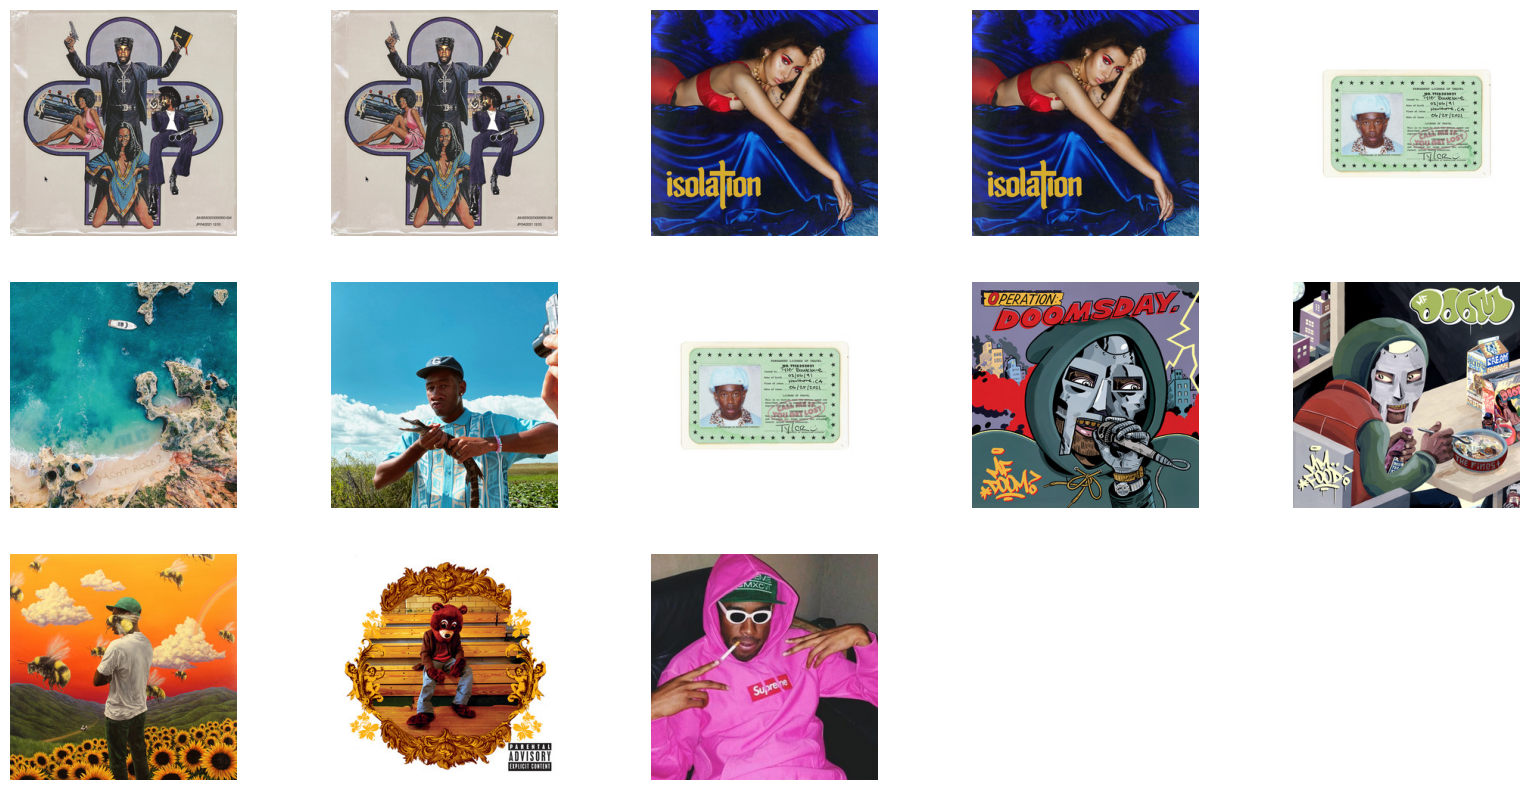

In [26]:
visualize_songs(playlist)

In [56]:
import pandas as pd

def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    # Ensure 'date_added' is in datetime format
    playlist_df['date_added'] = pd.to_datetime(playlist_df['date_added'])
    
    # Print column names and data types for debugging
    print("complete_feature_set columns and types:", complete_feature_set.dtypes)
    print("playlist_df columns and types:", playlist_df.dtypes)
    
    # Extract playlist and non-playlist feature sets
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['track_id'].isin(playlist_df['id'].values)]
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['track_id'].isin(playlist_df['id'].values)]
    
    # Merge playlist with date_added and sort by descending date_added
    playlist_feature_set = complete_feature_set_playlist.merge(
        playlist_df[['id', 'date_added']], 
        left_on='track_id', 
        right_on='id', 
        how='inner'
    ).sort_values('date_added', ascending=False)
    
    # Calculate weight based on months_from_recent
    most_recent_date = playlist_feature_set['date_added'].iloc[0]
    playlist_feature_set['months_from_recent'] = (most_recent_date - playlist_feature_set['date_added']).dt.days // 30
    
    # Ensure 'weight' is numeric and handle NaN values
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    playlist_feature_set['weight'] = pd.to_numeric(playlist_feature_set['weight'], errors='coerce')
    playlist_feature_set['weight'].fillna(0, inplace=True)  # Example: filling NaN with 0
    
    # Exclude specified columns
    columns_for_cosine_similarity = [col for col in playlist_feature_set.columns if col not in ['artist', 'id', 'date_added', 'name', 'genres', 'album']]
    playlist_feature_set_weighted_final = playlist_feature_set[columns_for_cosine_similarity]
    
    # Convert all relevant columns to numeric
    playlist_feature_set_weighted_final = playlist_feature_set_weighted_final.apply(pd.to_numeric, errors='coerce')
    
    # Print data types of the columns used for multiplication
    print("Data types of columns used for multiplication:", playlist_feature_set_weighted_final.dtypes)
    
    # Check for any NaN values in the weighted DataFrame
    print("NaN values in weighted DataFrame:", playlist_feature_set_weighted_final.isna().sum())
    
    # Ensure that `weight` is a Series that aligns with the rows of `playlist_feature_set_weighted_final`
    weights = playlist_feature_set['weight'].values
    
    # Check if `weights` and `playlist_feature_set_weighted_final` align properly
    if len(weights) != len(playlist_feature_set_weighted_final):
        raise ValueError("Length of weights and feature DataFrame rows do not match.")
    
    # Perform element-wise multiplication
    playlist_feature_set_weighted_final = playlist_feature_set_weighted_final.mul(weights[:, None], axis=0)
    
    # Return summed features and non-playlist features
    return playlist_feature_set_weighted_final.sum(axis=0), complete_feature_set_nonplaylist

# Example call
complete_feature_set_playlist_vector, complete_feature_set_nonplaylist_random = generate_playlist_feature(complete_feature_set, playlist, 1.09)


complete_feature_set columns and types: track_id                     object
track_name                   object
track_artist                 object
track_popularity              int64
track_album_id               object
track_album_name             object
track_album_release_date     object
playlist_name                object
playlist_id                  object
playlist_genre               object
playlist_subgenre            object
danceability                float64
energy                      float64
key                           int64
loudness                    float64
mode                          int64
speechiness                 float64
acousticness                float64
instrumentalness            float64
liveness                    float64
valence                     float64
tempo                       float64
duration_ms                   int64
playlist_genre|edm          float64
playlist_genre|latin        float64
playlist_genre|pop          float64
playlist_genre|rap      

In [61]:
complete_feature_set_playlist_vector.shape

(30,)

In [59]:
df['id'].dtype

dtype('O')

In [62]:
complete_feature_set_nonplaylist_random.shape

(32826, 28)

Top 40 Recommendations DataFrame:
                                    track_name_playlist  \
27330  If Only I Could (feat. Steve Lucas) - Liem Remix   
17410                   Enseñame a Soñar - Original Mix   
7376                     Sucker M.C.'s (Krush-Groove 1)   
23489                                      My Shit Bang   
6800                  Whatcha Know (featuring Big Gipp)   
18108                                          W. T. F.   
17270                                          Mera Woo   
6909                                          Diddy Pop   
17039                                     Need to Swing   
24459                                            Redeem   
18728                                   Outta Your Mind   
23687                                    Beat Goes Down   
9321                           Sneak Diss (feat. So6ix)   
18290              Heads High (Kill 'Em With It Re-Mix)   
26206                                       Personality   
6593                  

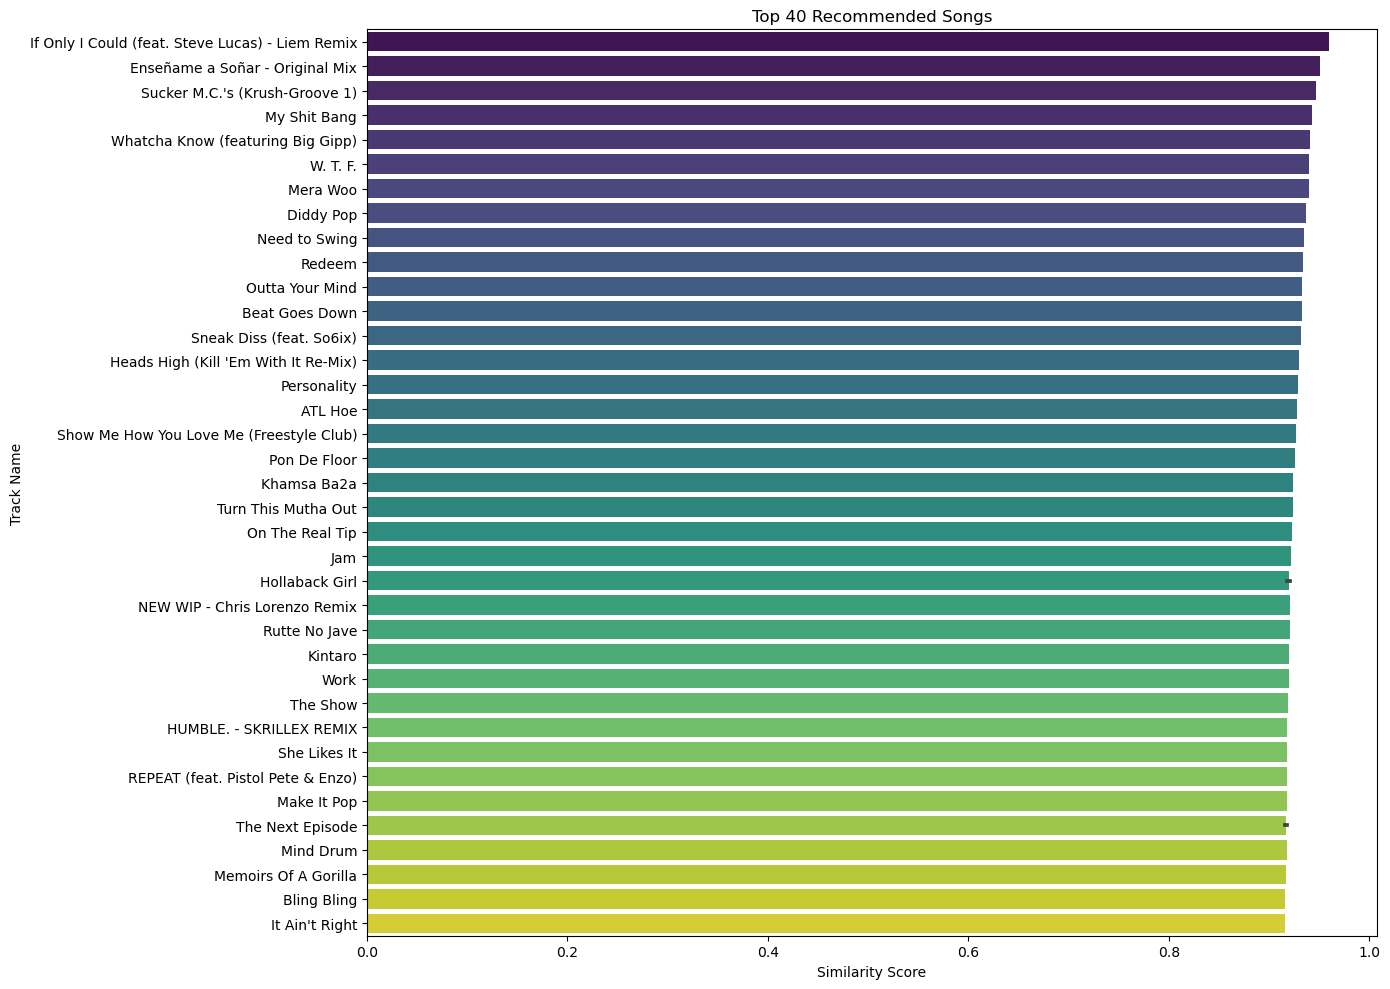

In [164]:
import pandas as pd
import seaborn as sns

def generate_playlist_recos(features, nonplaylist_features):
    # Rename the 'similarity_score' column in nonplaylist_features for clarity
    nonplaylist_features = nonplaylist_features.rename(columns={'similarity_score': 'similarity_score_nonplaylist'})
    
    # Merge DataFrames on 'track_id'
    merged_df = pd.merge(nonplaylist_features, features, on='track_id', how='inner')
    
    # Print merged DataFrame columns and preview for debugging
    print("Columns in merged DataFrame:", merged_df.columns)
    print("Merged DataFrame:")
    print(merged_df)
    
    # Sort by 'similarity_score' from the playlist vector
    if 'similarity_score' not in merged_df.columns:
        raise KeyError("'similarity_score' column is missing from merged DataFrame")
    
    top_recommendations_sorted = merged_df.sort_values(by='similarity_score', ascending=False)
    
    return top_recommendations_sorted



def visualize_songs(df):
    # Ensure 'track_id' and 'similarity_score' are available
    if 'track_id' not in df.columns or 'similarity_score' not in df.columns:
        raise KeyError("'track_id' or 'similarity_score' column is missing from DataFrame")

    temp = df['track_id'].tolist()
    columns = 5
    rows = (len(temp) // columns) + 1
    
    for i in range(rows):
        print(f"Row {i + 1}:")
        for j in range(columns):
            idx = i * columns + j
            if idx < len(temp):
                track_id = temp[idx]
                score = df.iloc[idx]['similarity_score']
                print(f"Track ID: {track_id}, Similarity Score: {score}")
        print()

# Example DataFrames for testing
# Example DataFrames for testing
# Example DataFrames
# Expanded Example DataFrame
playlist_df = df[['track_id', 'track_name', 'track_artist', 'track_album_name', 'playlist_genre', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]
nonplaylist_df = df[['track_id', 'track_name', 'track_artist', 'track_album_name', 'playlist_genre', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]

# Simulate similarity calculation (Example calculation; adjust as needed)
playlist_df['similarity_score_playlist'] = playlist_df[['danceability', 'energy']].mean(axis=1)
nonplaylist_df['similarity_score_nonplaylist'] = nonplaylist_df[['danceability', 'energy']].mean(axis=1)

# Drop duplicates if they exist
playlist_df = playlist_df.drop_duplicates(subset='track_id')
nonplaylist_df = nonplaylist_df.drop_duplicates(subset='track_id')

# Merge DataFrames on 'track_id'
merged_df = pd.merge(nonplaylist_df, playlist_df, on='track_id', suffixes=('_nonplaylist', '_playlist'))

# Remove exact duplicates in the merged DataFrame
merged_df = merged_df.drop_duplicates()

# Sort by similarity score from the playlist features
top_recommendations_sorted = merged_df.sort_values(by='similarity_score_playlist', ascending=False)

# Select top 40 recommendations
top_40_df = top_recommendations_sorted.head(40)

# Ensure the required columns are included for visualization
top_40_df = top_40_df[['track_name_playlist', 'track_artist_playlist', 'track_album_name_playlist', 'playlist_genre_playlist', 'similarity_score_playlist']]

# Function to visualize songs
def visualize_songs(df):
    # Ensure 'track_name_playlist' and 'similarity_score_playlist' are available
    if 'track_name_playlist' not in df.columns or 'similarity_score_playlist' not in df.columns:
        raise KeyError("'track_name_playlist' or 'similarity_score_playlist' column is missing from DataFrame")
    
    plt.figure(figsize=(14, 10))
    sns.barplot(x='similarity_score_playlist', y='track_name_playlist', data=df, palette='viridis')

    # Add labels and title
    plt.xlabel('Similarity Score')
    plt.ylabel('Track Name')
    plt.title('Top 40 Recommended Songs')
    plt.tight_layout()
    plt.show()

# Print the top 40 recommendations DataFrame
print("Top 40 Recommendations DataFrame:")
print(top_40_df)

# Visualize the top 40 recommendations
visualize_songs(top_40_df)





